# Robot Vision Tutorial #1

_Robot Vision_ refers to the task of processing images on a robot in order to extract useful information that the robot can use to make decisions.

In this tutorial, we focus on assembling some of the tools needed to process color and depth images in order to extract the location of objects. 

The data we will work with consists of three elements:
1. __Color images__: This is a normal image, which we refer to as "RGB" since it generally consists of three channels - red, green, and blue. 
2. __Depth images__: This is another type of image, but rather than a color at each pixel it reports the distance from the sensor to the nearest object. This is extremely useful for extracting geometric information about the scene.
3. __Rotations__: When the camera captures an image, it may be at an arbitrary orientation. This is annoying, since we'd really like to be able to use facts like "the coral reef is pretty vertical" to detect objects of interest. Luckily, the camera reports the rotation it was at when data was captured, which we can use to correct the orientation of the data. 

This tutorial is organized as follows:
  1. First, we load in the data and visualize it.
  2. Next, we go through image-space filtering techniques to extract color ranges we care about.
  3. We then convert the RGB and Depth images to _point clouds_, where more useful geometric information can be observed
  4. We apply techniques to extract shapes from point clouds
  5. We look at some geometric methods for determining where exactly the object of interest may be.

This notebook (filtering.ipynb) goes through steps 1-2. Stay tuned for the rest!

In [4]:
import os, sys
notebook_dir = os.getcwd()
sys.path.append(os.path.join(notebook_dir, os.pardir))

import cv2 # cv2 is the main import for OpenCV, a vision processing library: https://opencv.org/
import numpy as np # Numpy contains many vector and matrix tools. It's a very fast library: https://numpy.org/
import matplotlib.pyplot as plt # Useful for plotting
import ipywidgets as widgets # useful for interactive plotting
from ipywidgets import interact
from utils.load_data import load_data # Custom tools for loading data

data_sequence = 'reef_log_1'

data_dir = os.path.join(notebook_dir, os.pardir, 'data', data_sequence)


### Data Loading

In the next section, create a _generator_ `data_gen` for the data we will use. Generators are basically queues of data where you can only ever get the next element in the list.
Each time you call next(data_gen) you get three objects back:
1. RGB Image -> the color image of the scene
2. Depth Image -> The depth map recorded by the depth camera
3. Rotation -> The rotation matrix describing the orientation of the camera when the image was captured

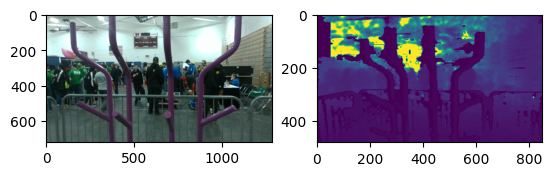

In [5]:
# Create a generator for the data
# we skip the first 25 frames while the camera's auto-focus and auto-white-balance is calibrating itself.
data_gen = load_data(data_dir, skip_num = 25)

# Grab the first RGBD (rgb + depth) image, as well as rotation
rgb, depth, rotation = next(data_gen)

# Plot the data
fig, ax = plt.subplots(1,2)
ax[0].imshow(rgb)
ax[1].imshow(depth)
plt.show()

## Image Filtering

Images captured in the real world are often noisy. To get rid of this noise an make processing easier, it often helps to first _blur_ the images. It may be counter-intuitive that blurring the image can improve the quality of processing... but hopefully this example shows that it can! We consider three types of filters:

1. Gaussian Blur: Gaussian blurring is a technique used to reduce noise and smooth images by convolving the image with a Gaussian kernel, which applies a weighted average of neighboring pixels to each pixel in the image.
2. Median Blur: Median blurring is a filtering technique that replaces each pixel's value with the median of the pixel values in its local neighborhood. It is particularly effective at removing salt-and-pepper noise while preserving edges.
3. Bilateral Filter: The bilateral filter smooths an image while keeping edges sharp. It does this by averaging nearby pixels, but it gives more weight to those with similar colors, so edges don’t get blurred like in other filters.

Each of these filters has a _kernel size_, which chooses how large a radius of neighboring pixels to consider when applying the filter. For example, a median blur with kernel size 11 makes each pixel the median value of the 11x11 square surrounding it.

Run the next cell and experiment with each filter to understand what they do.

In [51]:

# Filtering options
filter_type = widgets.Dropdown(
    options=["None", "Gaussian Blur", "Median Blur", "Bilateral Filter"],
    value="None",
    description="Filter Type"
)
filter_kernel = widgets.IntSlider(min=1, max=25, value=3, description="Kernel Size", step=2)

def apply_filter(filter_type, filter_kernel):
    filtered_image = rgb.copy()
    
    if filter_type == "Gaussian Blur":
        filtered_image = cv2.GaussianBlur(filtered_image, (filter_kernel, filter_kernel), 0)
    elif filter_type == "Median Blur":
        filtered_image = cv2.medianBlur(filtered_image, filter_kernel)
    elif filter_type == "Bilateral Filter":
        filtered_image = cv2.bilateralFilter(filtered_image, filter_kernel, 75, 75)
    return filtered_image

def apply_filter_and_draw(filter_type, filter_kernel):
    filtered_image = apply_filter(filter_type, filter_kernel)
    # Display results
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    
    axes[0].imshow(rgb)
    axes[0].axis("off")
    axes[0].set_title("Original Image")
    
    axes[1].imshow(filtered_image)
    axes[1].axis("off")
    axes[1].set_title(f"Filtered Image ({filter_type})")
    
    plt.show()

# Display interactive widgets
widgets.interactive(apply_filter_and_draw, filter_type=filter_type, filter_kernel=filter_kernel)


interactive(children=(Dropdown(description='Filter Type', options=('None', 'Gaussian Blur', 'Median Blur', 'Bi…

## Color Filtering

We often want to select a range of colors to keep in the image and get rid of everything else. Unfortunately, raw RGB values can be confusing to work with and often don't give great results when trying to filter with them.

Instead, we can use a different way to represent each color: HSV. This stands for hue, saturation, and value:

1. Hue: The color type (e.g., red, blue, green), represented as a number from 0 to 180. 
2. Saturation: How intense or faded the color is, where higher values mean more vivid colors.
3. Value: How bright the color is, ranging from black (0) to full brightness (255).
By filtering in the HSV space, we can easily pick a specific color range while ignoring changes in brightness or lighting.

The image below illustrates how H, S, and V interact. Note that the below image shows hue from 0 to 360, but we actually use values from 0 to 180... so, divide everything by 2!

<img src="https://giggster.com/guide/static/fed42130c194b0c240a4ec10408adf97/8282f/hsl-cover-2.png" style="background-color: white;">


You'll note that the purple values are mostly off to the right of the hue spectrum, which should give you a hint of how to choose H values for selecting the coral.

Run the below cell. You can set minimum and maximum values for Hue, Saturation, and Value, and see which parts of the image are discarded and which are kept in.

Try to get as close as possible to only including the reef. The visualization on the left shows the "mask", where white indicates that a pixel is included in the final image and black indicates that it's not. The other image shows the masked image, where all the pixels in the selected range are kept and the rest are discarded.



In [52]:
# Load the image
filtered_image = apply_filter(filter_type.value, filter_kernel.value)
hsv_image = cv2.cvtColor(filtered_image, cv2.COLOR_RGB2HSV)

# Create interactive widgets
h_min = widgets.IntSlider(min=0, max=179, value=0, description="Hue min")
h_max = widgets.IntSlider(min=0, max=179, value=179, description="Hue max")
s_min = widgets.IntSlider(min=1, max=255, value=1, description="Saturation min")
s_max = widgets.IntSlider(min=0, max=255, value=255, description="Saturation max")
v_min = widgets.IntSlider(min=0, max=255, value=0, description="Value min")
v_max = widgets.IntSlider(min=0, max=255, value=255, description="Value max")

def compute_hsv_mask(h_min, h_max, s_min, s_max, v_min, v_max):
    lower_bound = np.array([h_min, s_min, v_min])
    upper_bound = np.array([h_max, s_max, v_max])
    
    # Create mask
    mask = cv2.inRange(hsv_image, lower_bound, upper_bound)
    if mask.min() == mask.max():
        mask = np.zeros_like(mask) + 254
    
    return mask
    
def update_and_draw(h_min, h_max, s_min, s_max, v_min, v_max):
    mask = compute_hsv_mask(h_min, h_max, s_min, s_max, v_min, v_max)

    _, axes = plt.subplots(1, 2, figsize=(12, 6))
    
    axes[0].imshow(mask, cmap='gray')
    axes[0].axis("off")
    axes[0].set_title("Mask")

    masked_image = cv2.bitwise_and(filtered_image, filtered_image, mask=mask)
    axes[1].imshow(masked_image)
    axes[1].axis("off")
    axes[1].set_title("Masked Image")
    
    plt.show()

# Display interactive sliders
widgets.interactive(update_and_draw, h_min=h_min, h_max=h_max, s_min=s_min, s_max=s_max, v_min=v_min, v_max=v_max)

interactive(children=(IntSlider(value=0, description='Hue min', max=179), IntSlider(value=179, description='Hu…

## Morphological Filtering
After selecting a color range, the resulting mask may still contain noise, small gaps, or unwanted speckles. To clean up the mask and improve its quality, we can apply morphological operations. These operations refine the shape of the detected regions, making them more solid and connected.

The two main operations we use are:

__Erosion__: Shrinks white regions in the mask by removing small isolated pixels. This helps eliminate noise.
__Dilation__: Expands white regions, filling in small gaps and making objects more complete.
We alternate between these operations to achieve a balanced effect. The process runs for multiple cycles, allowing for finer control over the final mask.

Run the cell below to experiment with morphological filtering. You can adjust:

__Erode Kernel Size__: Controls how aggressively small details are removed.
__Dilate Kernel Size__: Controls how much gaps are filled in.
__Cycles__: The number of times the process repeats.
The left image shows the original mask, while the right image shows the processed version after applying morphological filtering. Try different values to see how they affect the mask!

In [53]:
erode_kernel_size = widgets.IntSlider(min=1, max=17, value=3, description="Erode Kernel Size", step=2)
dilate_kernel_size = widgets.IntSlider(min=1, max=17, value=3, description="Dilate Kernel Size", step=2)
iterations = widgets.IntSlider(min=1, max=10, value=1, description="Cycles")

lower_bound = np.array([h_min.value, s_min.value, v_min.value])
upper_bound = np.array([h_max.value, s_max.value, v_max.value])
mask = cv2.inRange(hsv_image, lower_bound, upper_bound)

def compute_morphology_mask(erode_kernel_size, dilate_kernel_size, iterations):

    
    erode_kernel = np.ones((erode_kernel_size, erode_kernel_size), np.uint8)
    dilate_kernel = np.ones((dilate_kernel_size, dilate_kernel_size), np.uint8)

    updated_mask = mask
    for i in range(iterations):
        if i % 2 == 0:
            updated_mask = cv2.dilate(updated_mask, dilate_kernel, iterations=1)  
            updated_mask = cv2.erode(updated_mask, erode_kernel, iterations=1)  
        else:
            updated_mask = cv2.erode(updated_mask, erode_kernel, iterations=1)  
            updated_mask = cv2.dilate(updated_mask, dilate_kernel, iterations=1)  

    return updated_mask


def compute_and_draw_morphology(erode_kernel_size, dilate_kernel_size, iterations):
    updated_mask = compute_morphology_mask(erode_kernel_size, dilate_kernel_size, iterations) 
    # Display results
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    
    axes[0].imshow(mask, cmap="gray")
    axes[0].axis("off")
    axes[0].set_title("Original Mask")
    
    axes[1].imshow(updated_mask, cmap="gray")
    axes[1].axis("off")
    axes[1].set_title(f"Processed ({iterations} Cycles)")

    plt.show()


# Display interactive widgets
widgets.interactive(compute_and_draw_morphology, erode_kernel_size=erode_kernel_size, 
                    dilate_kernel_size=dilate_kernel_size, 
                    iterations=iterations)

interactive(children=(IntSlider(value=3, description='Erode Kernel Size', max=17, min=1, step=2), IntSlider(va…

## All Together Now

The below cell combines all the above options to implement your filtering pipeline. Try to get it as tight as possible to the actual coral reef!

In [57]:
# %%
import matplotlib.gridspec as gridspec

final_mask = np.zeros(0,)

def process_image(filter_type, filter_kernel, h_min, h_max, s_min, s_max, v_min, v_max, 
                  erode_kernel_size, dilate_kernel_size, iterations):
    
    # Reload the original image
    rgb_image = rgb.copy()

    # Step 1: Apply chosen filter
    if filter_type == "Gaussian Blur":
        filtered_image = cv2.GaussianBlur(rgb_image, (filter_kernel, filter_kernel), 0)
    elif filter_type == "Median Blur":
        filtered_image = cv2.medianBlur(rgb_image, filter_kernel)
    elif filter_type == "Bilateral Filter":
        filtered_image = cv2.bilateralFilter(rgb_image, filter_kernel, 75, 75)
    else:
        filtered_image = rgb_image

    # Step 2: Convert to HSV and apply threshold
    hsv_image = cv2.cvtColor(filtered_image, cv2.COLOR_RGB2HSV)
    lower_bound = np.array([h_min, s_min, v_min])
    upper_bound = np.array([h_max, s_max, v_max])
    mask = cv2.inRange(hsv_image, lower_bound, upper_bound)

    # Step 3: Morphological processing
    erode_kernel = np.ones((erode_kernel_size, erode_kernel_size), np.uint8)
    dilate_kernel = np.ones((dilate_kernel_size, dilate_kernel_size), np.uint8)
    
    processed_mask = mask.copy()
    for i in range(iterations):
        if i % 2 == 0:
            processed_mask = cv2.dilate(processed_mask, dilate_kernel, iterations=1)
            processed_mask = cv2.erode(processed_mask, erode_kernel, iterations=1)
        else:
            processed_mask = cv2.erode(processed_mask, erode_kernel, iterations=1)
            processed_mask = cv2.dilate(processed_mask, dilate_kernel, iterations=1)
    
    masked_image = cv2.bitwise_and(filtered_image, filtered_image, mask=processed_mask)
    
    global final_mask
    final_mask = processed_mask

    fig = plt.figure(figsize=(14, 10))
    spec = gridspec.GridSpec(3, 2, height_ratios=[1, 1, 1.5])

    # First row: Original and Filtered Image
    ax1 = fig.add_subplot(spec[0, 0])
    ax1.imshow(rgb_image)
    ax1.axis("off")
    ax1.set_title("Original Image")

    ax2 = fig.add_subplot(spec[0, 1])
    ax2.imshow(filtered_image)
    ax2.axis("off")
    ax2.set_title(f"Filtered ({filter_type})")

    # Second row: Original Mask and Morphologically Processed Mask
    ax3 = fig.add_subplot(spec[1, 0])
    ax3.imshow(mask, cmap="gray")
    ax3.axis("off")
    ax3.set_title("Original HSV Mask")

    ax4 = fig.add_subplot(spec[1, 1])
    ax4.imshow(processed_mask, cmap="gray")
    ax4.axis("off")
    ax4.set_title(f"Morphologically Processed Mask ({iterations} Cycles)")

    # Final Row: Processed Image
    ax5 = fig.add_subplot(spec[2, :]) 
    ax5.imshow(masked_image)
    ax5.axis("off")
    ax5.set_title("Final Processed Image")

    plt.tight_layout()
    plt.show()


filter_type = widgets.Dropdown(
    options=["None", "Gaussian Blur", "Median Blur", "Bilateral Filter"],
    value=filter_type.value,
    description="Filter Type"
)
filter_kernel = widgets.IntSlider(min=1, max=25, value=filter_kernel.value, description="Filter Kernel Size", step=2)

h_min = widgets.IntSlider(min=0, max=179, value=h_min.value, description="Hue min")
h_max = widgets.IntSlider(min=0, max=179, value=h_max.value, description="Hue max")
s_min = widgets.IntSlider(min=1, max=255, value=s_min.value, description="Saturation min")
s_max = widgets.IntSlider(min=0, max=255, value=s_max.value, description="Saturation max")
v_min = widgets.IntSlider(min=0, max=255, value=v_min.value, description="Value min")
v_max = widgets.IntSlider(min=0, max=255, value=v_max.value, description="Value max")

erode_kernel_size = widgets.IntSlider(min=1, max=17, value=erode_kernel_size.value, description="Erode Kernel Size", step=2)
dilate_kernel_size = widgets.IntSlider(min=1, max=17, value=dilate_kernel_size.value, description="Dilate Kernel Size", step=2)
iterations = widgets.IntSlider(min=1, max=10, value=iterations.value, description="Cycles")

# Create interactive UI
interactive_widget = widgets.interactive(
    process_image,
    filter_type=filter_type, filter_kernel=filter_kernel,
    h_min=h_min, h_max=h_max, s_min=s_min, s_max=s_max,
    v_min=v_min, v_max=v_max, erode_kernel_size=erode_kernel_size,
    dilate_kernel_size=dilate_kernel_size, iterations=iterations
)

display(interactive_widget)


interactive(children=(Dropdown(description='Filter Type', index=3, options=('None', 'Gaussian Blur', 'Median B…

When you're happy with the results, run the next cell to save them. 

The next step is moving to 3D and extracting the geometry of the actual reef.

In [62]:
## Save the final mask
os.makedirs(os.path.join(notebook_dir, os.pardir, 'tutorial_data'), exist_ok=True)
cv2.imwrite(os.path.join(notebook_dir, os.pardir, 'tutorial_data', 'rgb.png'), cv2.cvtColor(rgb, cv2.COLOR_RGB2BGR))
np.save(os.path.join(notebook_dir, os.pardir, 'tutorial_data', 'depth.npy'), depth)
np.save(os.path.join(notebook_dir, os.pardir, 'tutorial_data', 'mask.npy'), final_mask)